In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from itertools import product
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import itertools
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import LabelEncoder
import warnings
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import statsmodels.api as sm
%matplotlib inline
# Ignore warnings
warnings.filterwarnings("ignore")

## Data Wrangling

In [3]:
# Importing the Dataset and merging with external Country to Continent File
passenger = pd.read_csv(r'Passanger_booking_data.csv', encoding='utf-8')
passenger.drop_duplicates(inplace=True)

countries = pd.read_csv('Countries-Continents.csv')
passenger = pd.merge(passenger, countries,
                     left_on='booking_origin', right_on='Country', how='left')
passenger = passenger.drop(columns='Country', axis=1)

In [4]:
# Get the mode (most frequent value)
most_frequent_value = passenger['Continent'].mode().iloc[0]
passenger['Continent'].fillna(most_frequent_value, inplace=True)

In [5]:
# Select numerical columns
numerical_columns = passenger.select_dtypes(
    include=['float64', 'int64']).columns


passenger = passenger.drop(columns=['trip_type', 'route'], axis=1)

# Create a all_services feature
passenger['all_services'] = passenger['wants_extra_baggage'] + \
    passenger['wants_preferred_seat'] + passenger['wants_in_flight_meals']

# Create an is_weekend feature
passenger['weekend_flight'] = passenger['flight_day'].isin(
    ['Sat', 'Sun']).astype(int)

# Define the ranges for each category
ranges = [(0, 5), (6, 11), (12, 17), (18, 21), (22, 23)]
labels = ['Night', 'Morning', 'Afternoon', 'Evening', 'Night']

# Create a new column 'category' and assign the appropriate label based on the value's range
passenger['flight_time'] = pd.cut(passenger['flight_hour'], bins=[
                                  range[0] for range in ranges] + [ranges[-1][1]], labels=labels, right=False, ordered=False)

# Get the mode (most frequent value)
most_frequent_value = passenger['flight_time'].mode().iloc[0]
passenger['flight_time'].fillna(most_frequent_value, inplace=True)

# Determine the range of values in the 'days_in_advance' column
min_value = passenger['purchase_lead'].min()
max_value = passenger['purchase_lead'].max()

# Define the bin edges for quarters
# + 92 to include the upper bound in the last bin
bin_edges = np.arange(min_value, max_value + 92, 91)

# Define the labels for each quarter
labels = [f"Quarter {i+1}" for i in range(len(bin_edges) - 1)]

# Create a new column 'quarter_booked' and assign the appropriate quarter label based on the value
passenger['quarter_booked'] = pd.cut(
    passenger['purchase_lead'], bins=bin_edges, labels=labels, right=False)

# Using qcut to create 10 bins
passenger['lead_bins'] = pd.qcut(passenger['purchase_lead'], q=10)

## Exploratory Data Analysis 


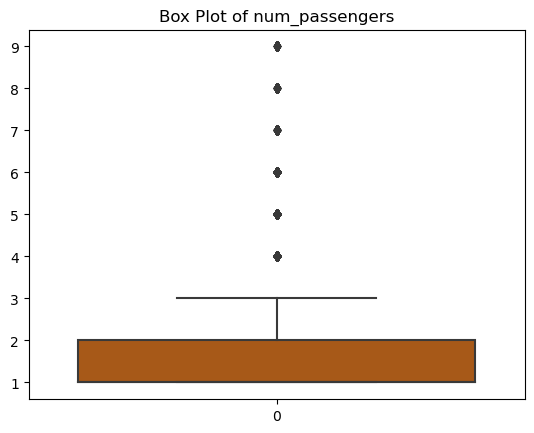

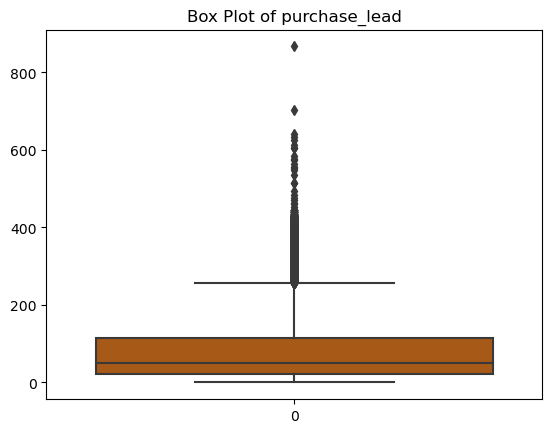

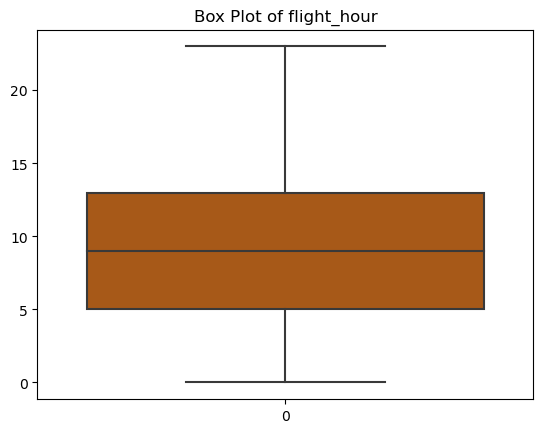

In [14]:
# Outlier checking
for column in columns:
    sns.boxplot(data=new_passenger[column], color='#BF5700')
    plt.title(f'Box Plot of {column}')
    plt.show()

### Outliers
* Even though we see some outliers in the box plots for num_passengers and purchase_lead, we still want to consider them because the number of passengers can vary, and it is expected that the customers might book in advance.

In [6]:
new_passenger = passenger.loc[(passenger['Continent'] == 'Asia') | (
    passenger['Continent'] == 'Oceania')]

In [7]:
# Understanding booking decisions by number of passengers
df_num_passengers = new_passenger.groupby('num_passengers', dropna=False).agg(
    {'booking_complete': ['count', 'mean']}).reset_index()

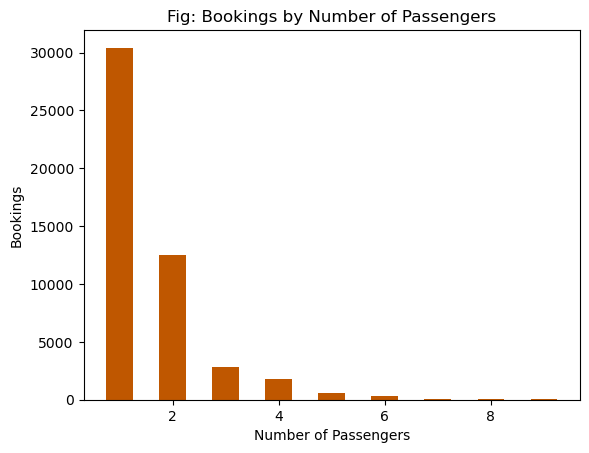

In [8]:
# Understanding the bookings by number of passengers
plt.bar(df_num_passengers['num_passengers'],
        df_num_passengers['booking_complete']['count'], width=0.5, color='#BF5700')
plt.xlabel('Number of Passengers')
plt.ylabel('Bookings')
plt.title('Fig: Bookings by Number of Passengers')
plt.show()

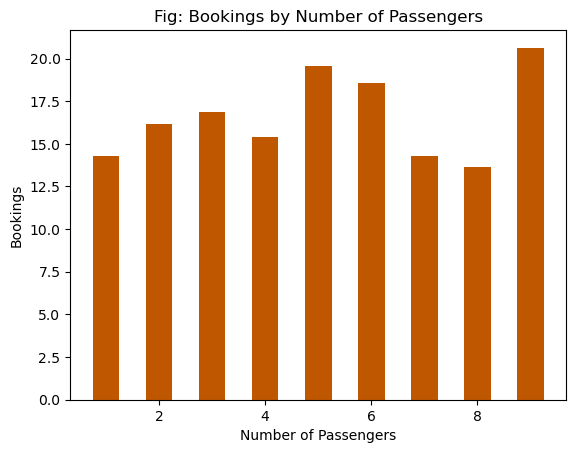

In [9]:
# Understanding the bookings by number of passengers
plt.bar(df_num_passengers['num_passengers'],
        df_num_passengers['booking_complete']['mean']*100, width=0.5, color='#BF5700')
plt.xlabel('Number of Passengers')
plt.ylabel('Bookings')
plt.title('Fig: Bookings by Number of Passengers')
plt.show()

In [10]:
# Understanding booking decisions by flight hour
df_flight_hour = new_passenger.groupby('flight_hour', dropna=False).agg(
    {'booking_complete': ['count', 'mean']}).reset_index()

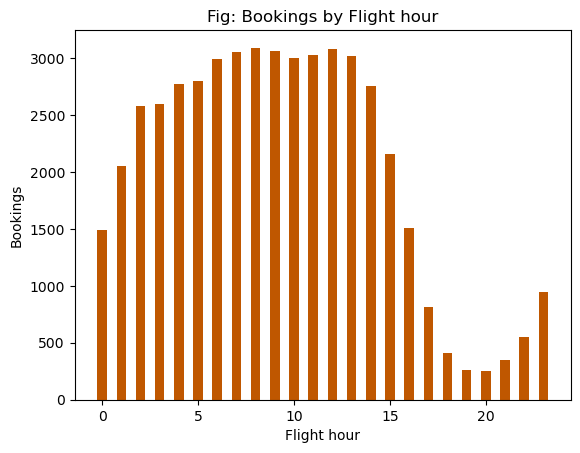

In [11]:
# Understanding the bookings by flight hour
plt.bar(df_flight_hour['flight_hour'], df_flight_hour['booking_complete']
        ['count'], width=0.5, color='#BF5700')
plt.xlabel('Flight hour')
plt.ylabel('Bookings')
plt.title('Fig: Bookings by Flight hour')
plt.show()

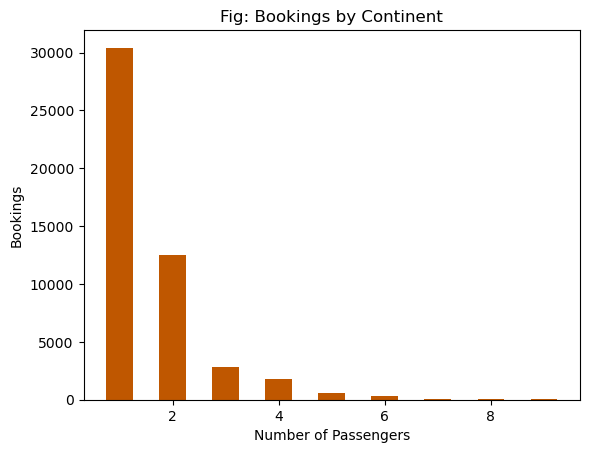

In [12]:
# 1. Understanding the booking completion rate by contient
plt.bar(df_num_passengers['num_passengers'],
        df_num_passengers['booking_complete']['count'], width=0.5, color='#BF5700')
plt.xlabel('Number of Passengers')
plt.ylabel('Bookings')
plt.title('Fig: Bookings by Continent')
plt.show()

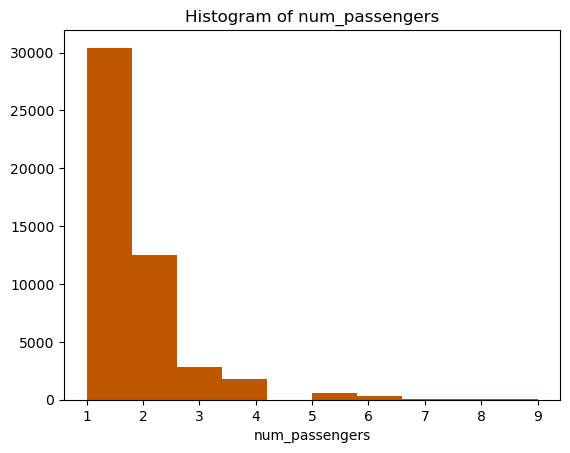

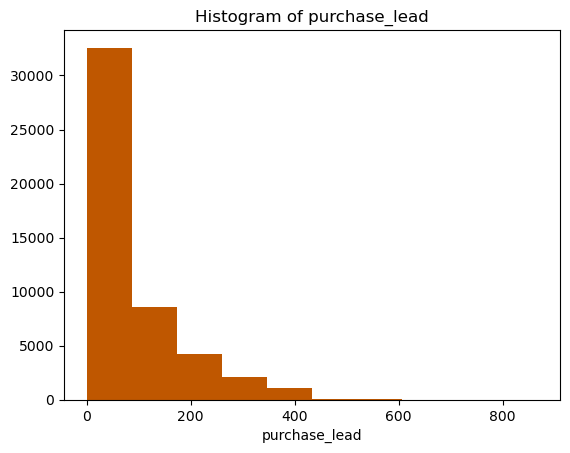

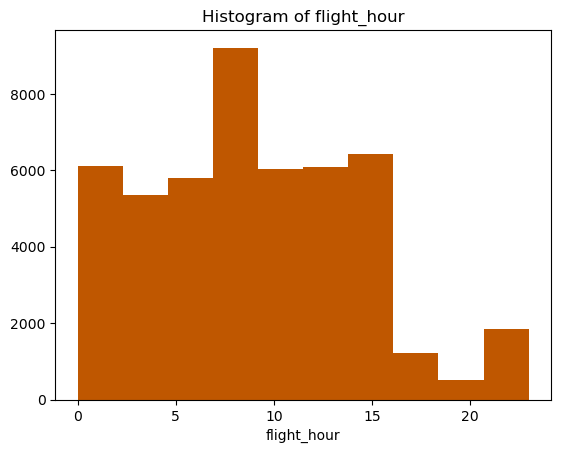

In [13]:
# Understanding feature distributions
columns = ['num_passengers', 'purchase_lead', 'flight_hour']

for column in columns:
    sns.distplot(new_passenger[column], kde=False,
                 bins=10, color='#BF5700', hist_kws={'alpha': 1})
    plt.title(f'Histogram of {column}')
    plt.show()

In [15]:
# 1. Understanding booking decisions by continent
df_continent = new_passenger.groupby('Continent', dropna=False).agg(
    {'booking_complete': ['count', 'mean']}).reset_index()

In [16]:
# 1. Understanding booking decisions by continent
df_all_continent = passenger.groupby('Continent', dropna=False).agg(
    {'booking_complete': ['count', 'mean']}).reset_index()

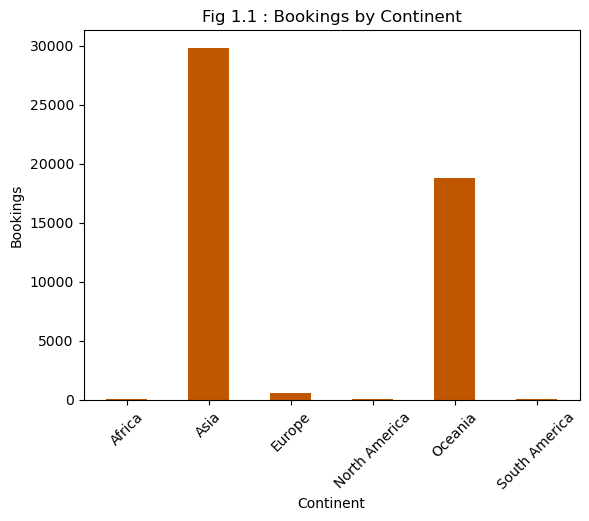

In [17]:
# 1. Understanding the bookings by contient
plt.bar(df_all_continent['Continent'], df_all_continent['booking_complete']
        ['count'], width=0.5, color='#BF5700')
plt.xlabel('Continent')
plt.ylabel('Bookings')
plt.title('Fig 1.1 : Bookings by Continent')
plt.xticks(rotation=45)
plt.show()

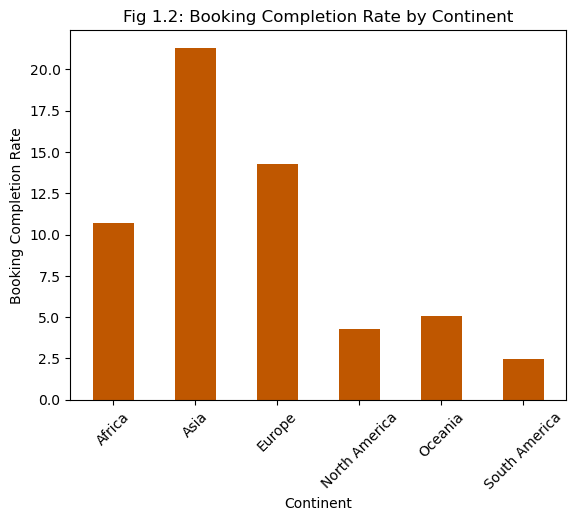

In [18]:
# 1. Understanding the booking completion rate by contient
plt.bar(df_all_continent['Continent'], df_all_continent['booking_complete']
        ['mean']*100, width=0.5, color='#BF5700')
plt.xlabel('Continent')
plt.ylabel('Booking Completion Rate')
plt.title('Fig 1.2: Booking Completion Rate by Continent')
plt.xticks(rotation=45)
plt.show()

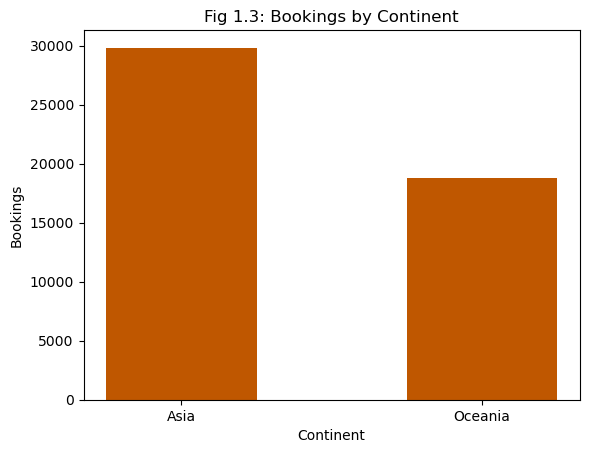

In [19]:
# 1. Understanding the bookings by contient
plt.bar(df_continent['Continent'], df_continent['booking_complete']
        ['count'], width=0.5, color='#BF5700')
plt.xlabel('Continent')
plt.ylabel('Bookings')
plt.title('Fig 1.3: Bookings by Continent')
plt.show()

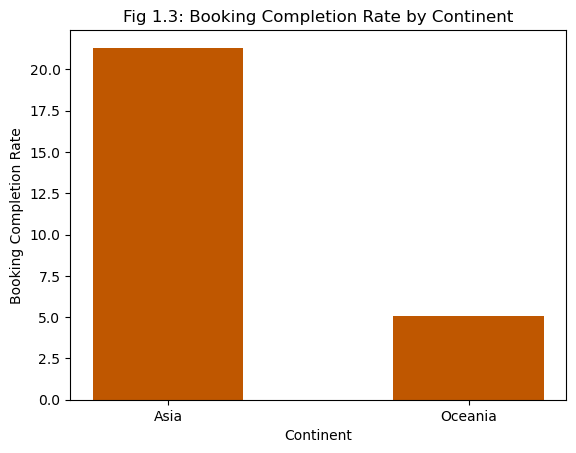

In [20]:
# 1. Understanding the booking completion rate by contient
plt.bar(df_continent['Continent'], df_continent['booking_complete']
        ['mean']*100, width=0.5, color='#BF5700')
plt.xlabel('Continent')
plt.ylabel('Booking Completion Rate')
plt.title('Fig 1.3: Booking Completion Rate by Continent')
plt.show()

**Insight 1:** From the bar graph it is observed that booking completion from Asia is 5 times more likely than in Oceania.

In [21]:
#  2. Evaluating the impact of different services on customers' booking decisions
extra_bag_df = new_passenger.groupby('wants_extra_baggage').agg(
    {'booking_complete': ['count', 'mean']}).reset_index()  # .set_index('wants_extra_baggage')

In [22]:
extra_bag_df.loc[extra_bag_df['wants_extra_baggage']
                 == 0, 'wants_extra_baggage'] = 'Not Opted'
extra_bag_df.loc[extra_bag_df['wants_extra_baggage']
                 == 1, 'wants_extra_baggage'] = 'Opted'

In [23]:
extra_bag_df.set_index('wants_extra_baggage')

booking_complete          
                               count      mean
wants_extra_baggage                           
Not Opted                      16113  0.115124
Opted                          32471  0.167873

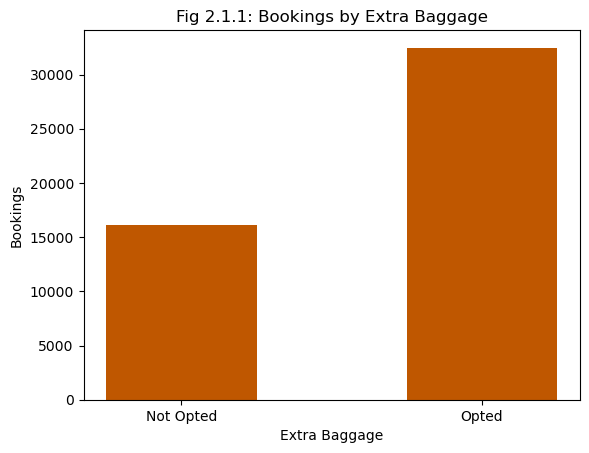

In [24]:
plt.bar(extra_bag_df['wants_extra_baggage'],
        extra_bag_df['booking_complete']['count'], width=0.5, color='#BF5700')
plt.xlabel('Extra Baggage')
plt.ylabel('Bookings')
plt.title('Fig 2.1.1: Bookings by Extra Baggage')
plt.show()

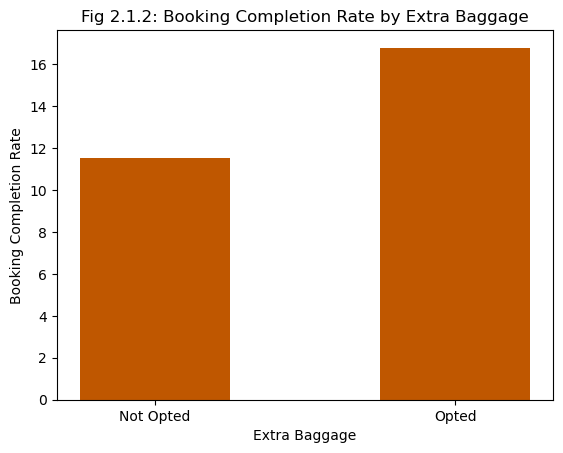

In [25]:
plt.bar(extra_bag_df['wants_extra_baggage'],
        extra_bag_df['booking_complete']['mean']*100, width=0.5, color='#BF5700')
plt.xlabel('Extra Baggage')
plt.ylabel('Booking Completion Rate')
plt.title('Fig 2.1.2: Booking Completion Rate by Extra Baggage')
plt.show()

In [26]:
extra_seats_df = new_passenger.groupby('wants_preferred_seat').agg(
    {'booking_complete': ['count', 'mean']}).reset_index()

In [27]:
extra_seats_df.loc[extra_seats_df['wants_preferred_seat']
                   == 0, 'wants_preferred_seat'] = 'Not Opted'
extra_seats_df.loc[extra_seats_df['wants_preferred_seat']
                   == 1, 'wants_preferred_seat'] = 'Opted'

In [28]:
extra_seats_df

wants_preferred_seat booking_complete          
                                  count      mean
0            Not Opted            34215  0.138740
1                Opted            14369  0.178092

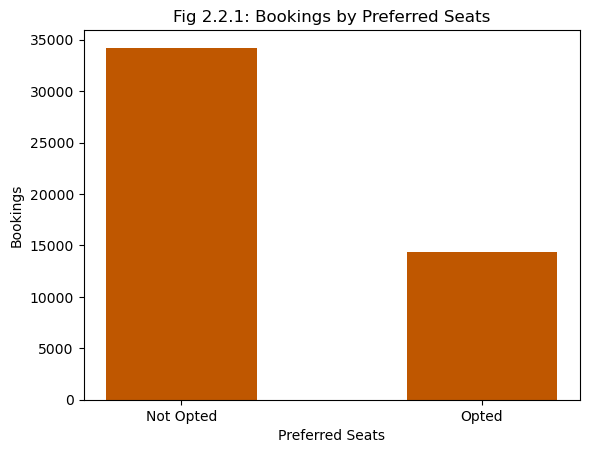

In [29]:
plt.bar(extra_seats_df['wants_preferred_seat'],
        extra_seats_df['booking_complete']['count'], width=0.5, color='#BF5700')
plt.xlabel('Preferred Seats')
plt.ylabel('Bookings')
plt.title('Fig 2.2.1: Bookings by Preferred Seats')
plt.show()

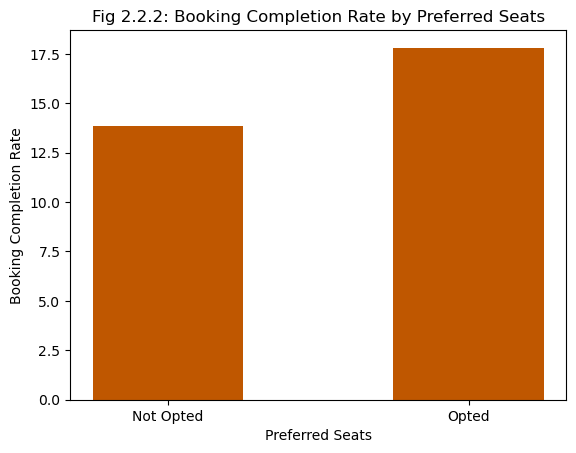

In [30]:
plt.bar(extra_seats_df['wants_preferred_seat'],
        extra_seats_df['booking_complete']['mean']*100, width=0.5, color='#BF5700')
plt.xlabel('Preferred Seats')
plt.ylabel('Booking Completion Rate')
plt.title('Fig 2.2.2: Booking Completion Rate by Preferred Seats')
plt.show()

In [31]:
#  2. Evaluating the impact of different services on customers' booking decisions
meals_df = new_passenger.groupby('wants_in_flight_meals').agg(
    {'booking_complete': ['count', 'mean']}).reset_index()

In [32]:
meals_df.loc[meals_df['wants_in_flight_meals']
             == 0, 'wants_in_flight_meals'] = 'Not Opted'
meals_df.loc[meals_df['wants_in_flight_meals']
             == 1, 'wants_in_flight_meals'] = 'Opted'

In [33]:
meals_df

wants_in_flight_meals booking_complete          
                                   count      mean
0             Not Opted            27841  0.142488
1                 Opted            20743  0.160970

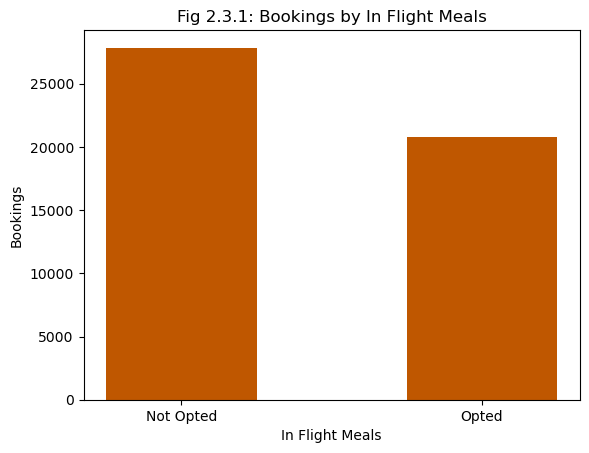

In [34]:
plt.bar(meals_df['wants_in_flight_meals'],
        meals_df['booking_complete']['count'], width=0.5, color='#BF5700')
plt.xlabel('In Flight Meals')
plt.ylabel('Bookings')
plt.title('Fig 2.3.1: Bookings by In Flight Meals')
plt.show()

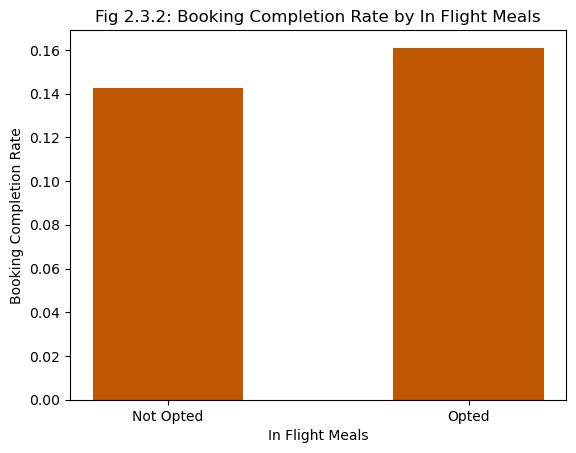

In [35]:
plt.bar(meals_df['wants_in_flight_meals'],
        meals_df['booking_complete']['mean'], width=0.5, color='#BF5700')
plt.xlabel('In Flight Meals')
plt.ylabel('Booking Completion Rate')
plt.title('Fig 2.3.2: Booking Completion Rate by In Flight Meals')
plt.show()

In [36]:
all_services_df = new_passenger.groupby('all_services').agg(
    {'booking_complete': ['count', 'mean']}).reset_index()

In [37]:
all_services_df

all_services booking_complete          
                          count      mean
0            0            10191  0.106859
1            1            17700  0.150960
2            2            12196  0.160544
3            3             8497  0.186772

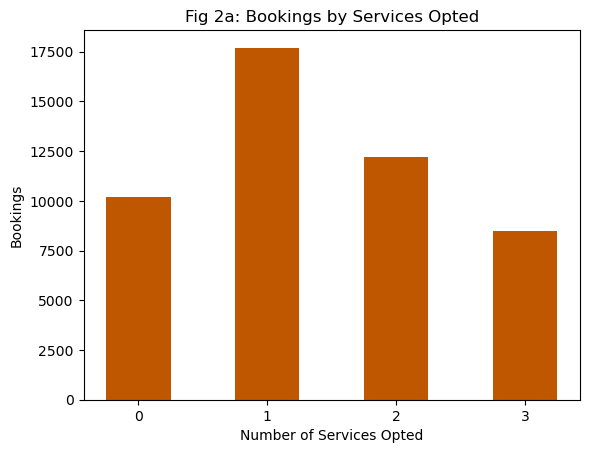

In [38]:
plt.bar(all_services_df['all_services'],
        all_services_df['booking_complete']['count'], width=0.5, color='#BF5700')
plt.xlabel('Number of Services Opted')
plt.ylabel('Bookings')
plt.title('Fig 2a: Bookings by Services Opted')
plt.xticks(all_services_df['all_services'])
plt.show()

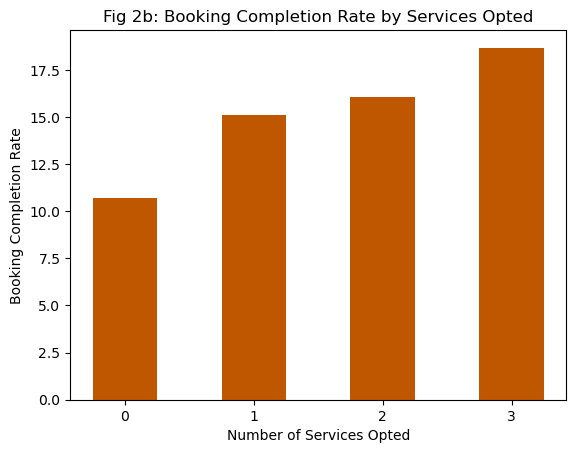

In [39]:
plt.bar(all_services_df['all_services'], all_services_df['booking_complete']
        ['mean']*100, width=0.5, color='#BF5700')
plt.xlabel('Number of Services Opted')
plt.ylabel('Booking Completion Rate')
plt.title('Fig 2b: Booking Completion Rate by Services Opted')
plt.xticks(all_services_df['all_services'])
plt.show()

**Insight 2:** Booking completion is proportional to In-flight services.
* Individual Services & Services All together have the same effect – Increasing the chance of booking completion.
* Those who opt for all services have significantly higher booking completion rate.
* Try and offer services at a cheaper rate or complimentary if booked early so completion rate goes up.


In [40]:
# 3. Evaluating the impact of purchase lead on customer's booking decisions
purchase_lead_df = new_passenger.groupby('lead_bins').agg(
    {'booking_complete': ['count', 'mean']}).reset_index()

In [41]:
purchase_lead_df

lead_bins booking_complete          
                             count      mean
0   (-0.001, 8.0]             5319  0.174093
1     (8.0, 16.0]             4447  0.176299
2    (16.0, 26.0]             5165  0.152372
3    (26.0, 37.0]             4549  0.150802
4    (37.0, 51.0]             4927  0.155267
5    (51.0, 69.0]             4779  0.145009
6    (69.0, 96.0]             4933  0.134604
7   (96.0, 140.0]             4750  0.138526
8  (140.0, 223.0]             4847  0.130803
9  (223.0, 867.0]             4868  0.145645

In [42]:
lead_bins = []
for value in purchase_lead_df['lead_bins'].values:
    lead_bins.append(str(value))

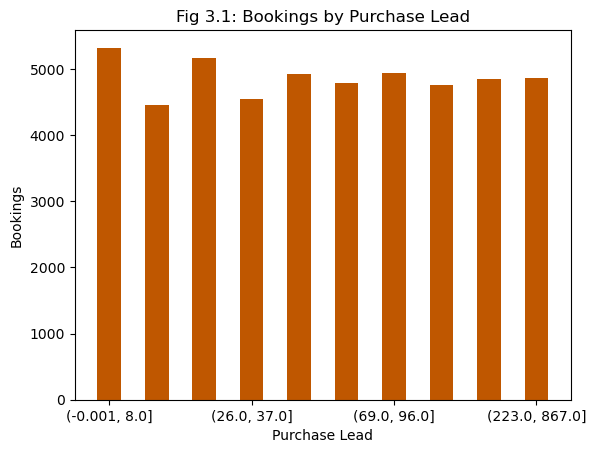

In [43]:
plt.bar(lead_bins, purchase_lead_df['booking_complete']
        ['count'], width=0.5, color='#BF5700')
plt.xlabel('Purchase Lead')
plt.ylabel('Bookings')
plt.title('Fig 3.1: Bookings by Purchase Lead')
plt.xticks(lead_bins[::3])
plt.show()

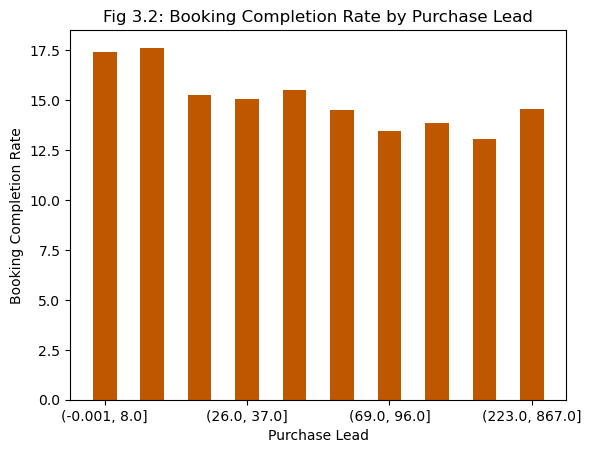

In [44]:
plt.bar(lead_bins, purchase_lead_df['booking_complete']
        ['mean']*100, width=0.5, color='#BF5700')
plt.xlabel('Purchase Lead')
plt.ylabel('Booking Completion Rate')
plt.title('Fig 3.2: Booking Completion Rate by Purchase Lead')
plt.xticks(lead_bins[::3])
plt.show()

**Insight 3:** Booking is expected if the customer is close to the booking date.

In [45]:
# 4. Evaluating the impact of time of flight on customers' booking decisions
flight_time_df = new_passenger.groupby('flight_time').agg(
    {'booking_complete': ['count', 'mean']}).reset_index()

In [46]:
flight_time_df

flight_time booking_complete          
                         count      mean
0   Afternoon            13315  0.167781
1     Evening             1266  0.142180
2     Morning            19170  0.144653
3       Night            14833  0.142857

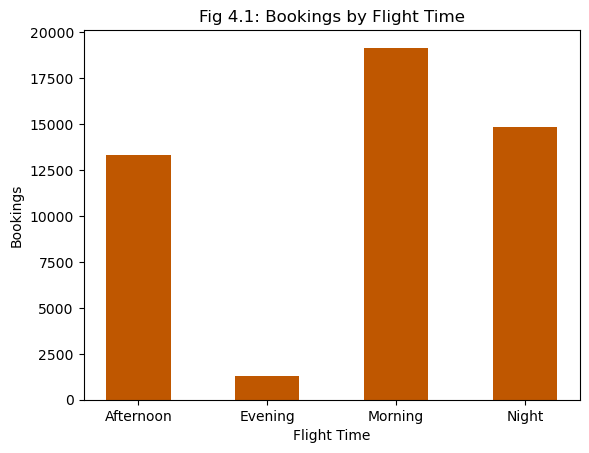

In [47]:
plt.bar(flight_time_df['flight_time'], flight_time_df['booking_complete']
        ['count'], width=0.5, color='#BF5700')
plt.xlabel('Flight Time')
plt.ylabel('Bookings')
plt.title('Fig 4.1: Bookings by Flight Time')
plt.xticks(all_services_df['all_services'])
plt.show()

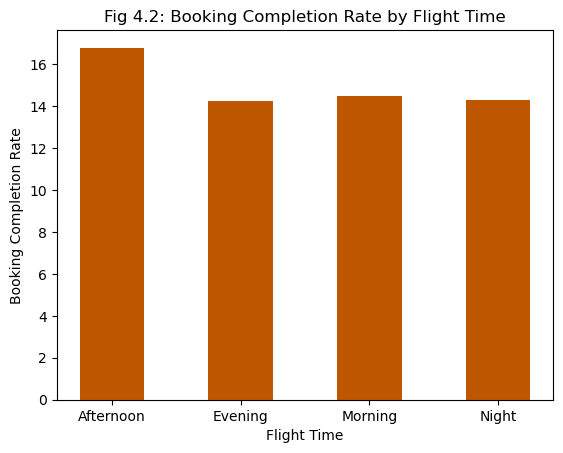

In [48]:
plt.bar(flight_time_df['flight_time'], flight_time_df['booking_complete']
        ['mean']*100, width=0.5, color='#BF5700')
plt.xlabel('Flight Time')
plt.ylabel('Booking Completion Rate')
plt.title('Fig 4.2: Booking Completion Rate by Flight Time')
plt.xticks(all_services_df['all_services'])
plt.show()

**Insight 4:** The time of day has no significant effect on the booking completion.

In [49]:
# 4. Evaluating the impact of time of flight on customers' booking decisions
sales_channel_df = new_passenger.groupby('sales_channel').agg(
    {'booking_complete': ['count', 'mean']}).reset_index()

In [50]:
# 5. Evaluating the impact of sales channel on customers' booking decisions
df_internet = new_passenger[new_passenger['sales_channel'] == 'Internet']
df_mobile = new_passenger[new_passenger['sales_channel'] == 'Mobile']

In [51]:
random_rows_with_seed = df_internet.sample(n=5300, random_state=42)
appended_df = random_rows_with_seed.append(df_mobile, ignore_index=True)

In [52]:
appended_df = appended_df.groupby('sales_channel').agg(
    {'booking_complete': ['count', 'mean']}).reset_index()

In [53]:
appended_df

sales_channel booking_complete          
                           count      mean
0      Internet             5300  0.156792
1        Mobile             5324  0.110255

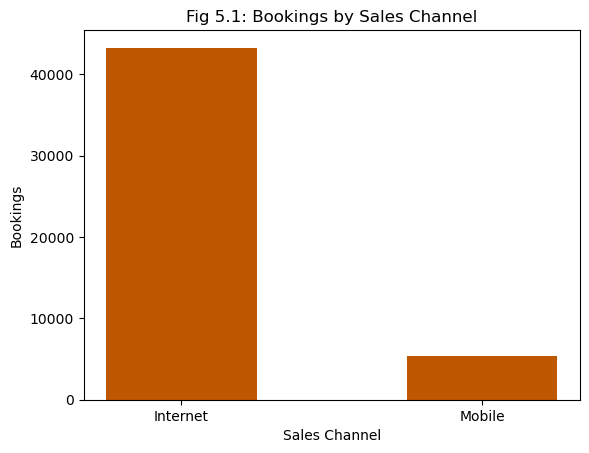

In [54]:
plt.bar(sales_channel_df['sales_channel'],
        sales_channel_df['booking_complete']['count'], width=0.5, color='#BF5700')
plt.xlabel('Sales Channel')
plt.ylabel('Bookings')
plt.title('Fig 5.1: Bookings by Sales Channel')
plt.show()

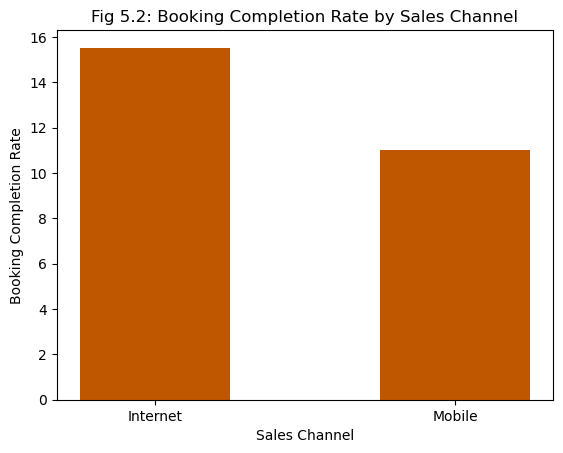

In [55]:
plt.bar(sales_channel_df['sales_channel'], sales_channel_df['booking_complete']
        ['mean']*100, width=0.5, color='#BF5700')
plt.xlabel('Sales Channel')
plt.ylabel('Booking Completion Rate')
plt.title('Fig 5.2: Booking Completion Rate by Sales Channel')
plt.show()

**Insight 5:** Internet channel seems to be the preference for booking a holiday.
* Try and improve the mobile UX which may lead to more booking completions through mobile channel.


## Modeling Dataset Preparation

In [56]:
# Select categorical columns
categorical_columns = passenger.select_dtypes(
    include=['object', 'category']).columns


# Function to label encode categorical columns based on value counts
def label_encode_by_value_counts(df, columns):
    for col in columns:
        value_counts = df[col].value_counts()
        label_encoder = LabelEncoder()
        label_encoder.fit(value_counts.index)
        df[col] = label_encoder.transform(df[col])


# Label encode the categorical columns based on value counts
label_encode_by_value_counts(passenger, categorical_columns)

In [57]:
passenger['booking_complete'].value_counts(normalize=True)

0    0.850009
1    0.149991
Name: booking_complete, dtype: float64

In [58]:
# Separate the majority and minority classes
minority_class = passenger[passenger['booking_complete'] == 1]
majority_class = passenger[passenger['booking_complete'] == 0]

# Count the number of instances in the minority class
num_minority_class = len(minority_class)

# Sample the majority class to match the number of instances in the minority class
undersampled_majority_class = majority_class.sample(
    n=num_minority_class, random_state=42)

# Concatenate the undersampled majority class and the minority class
undersampled_df = pd.concat([undersampled_majority_class, minority_class])

# Shuffle the DataFrame to ensure a random order of samples
passenger = undersampled_df.sample(frac=1, random_state=42)

In [59]:
passenger.shape

(14784, 18)

In [60]:
passenger['booking_complete'].value_counts(normalize=True)

1    0.5
0    0.5
Name: booking_complete, dtype: float64

In [61]:
# Splitting data into X and y datasets based on the target variable
X = passenger.drop('booking_complete', axis=1)
y = passenger['booking_complete']

In [62]:
# Split the dataset into training, validation, and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.3, random_state=42)

## K-Nearest Neighbours Classifier

In [63]:
# Define parameter combinations for each model
k_values = range(1, 51)  # Number of neighbors (k) to consider, from 1 to 50
knn_params = k_values

# Set random seed for reproducibility
np.random.seed(42)

# Initialize a list to store accuracy values
accuracies = []
precisions = []
recalls = []

# Perform k-fold cross-validation for parameter combinations
for k in knn_params:
    print("Testing parameter combination: k={}".format(k))

    # Create the KNN Classifier
    model = KNeighborsClassifier(n_neighbors=k)

    # Perform k-fold cross-validation and get accuracy, precision, and recall scores
    cv_scores_accuracy = cross_val_score(
        model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_precision = cross_val_score(
        model, X_train, y_train, cv=5, scoring='precision')
    cv_scores_recall = cross_val_score(
        model, X_train, y_train, cv=5, scoring='recall')

    # Calculate mean scores for accuracy, precision, and recall
    accuracy = np.mean(cv_scores_accuracy)
    precision = np.mean(cv_scores_precision)
    recall = np.mean(cv_scores_recall)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

    print("Cross-Validation Accuracy:", accuracy)
    print("Cross-Validation Precision:", precision)
    print("Cross-Validation Recall:", recall)
    print()

# Find the best hyperparameter based on the validation set performance
best_k = knn_params[np.argmax(accuracies)]
print("Best k:", best_k)

# Train the final model using the best hyperparameter on the training set
final_model = KNeighborsClassifier(n_neighbors=best_k)
final_model.fit(X_train, y_train)

# Make probability predictions on the testing set
y_test_prob = final_model.predict_proba(X_test)

# Set threshold and convert probabilities to binary predictions
y_test_pred = (y_test_prob[:, 1] >= 0.51).astype(int)

Testing parameter combination: k=1
Cross-Validation Accuracy: 0.5978504604696645
Cross-Validation Precision: 0.6014901582836114
Cross-Validation Recall: 0.6067832325357924

Testing parameter combination: k=2
Cross-Validation Accuracy: 0.5866168979961178
Cross-Validation Precision: 0.653463483166484
Cross-Validation Recall: 0.38891512191227334

Testing parameter combination: k=3
Cross-Validation Accuracy: 0.6186283696017048
Cross-Validation Precision: 0.6197945216053149
Cross-Validation Recall: 0.6361645038679452

Testing parameter combination: k=4
Cross-Validation Accuracy: 0.6099300173679525
Cross-Validation Precision: 0.6529251483851903
Cross-Validation Recall: 0.4880491469990276

Testing parameter combination: k=5
Cross-Validation Accuracy: 0.6292578484171811
Cross-Validation Precision: 0.631240516133267
Cross-Validation Recall: 0.6418952789112155

Testing parameter combination: k=6
Cross-Validation Accuracy: 0.6218897499890538
Cross-Validation Precision: 0.6530670597924805
Cross-Va

Cross-Validation Accuracy: 0.6425468131996439
Cross-Validation Precision: 0.6312024367108533
Cross-Validation Recall: 0.7061601982304115

Testing parameter combination: k=50
Cross-Validation Accuracy: 0.6418216646963527
Cross-Validation Precision: 0.634060909571441
Cross-Validation Recall: 0.6906328146608384

Best k: 33


In [64]:
# Make probability predictions on the validation set
y_val_prob = final_model.predict_proba(X_val)

# Set threshold and convert probabilities to binary predictions
y_val_pred = (y_val_prob[:, 1] >= 0.51).astype(int)

# Calculate accuracy, precision, and recall on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)

print("Validation Accuracy:", accuracy)
print("Validation Precision:", precision)
print("Validation Recall:", recall)

Validation Accuracy: 0.631163708086785
Validation Precision: 0.6090185676392573
Validation Recall: 0.6674418604651163


In [65]:
# Calculate accuracy, precision, and recall on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("Final Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Final Test Accuracy: 0.6449103821440649
Test Precision: 0.6352357320099256
Test Recall: 0.6890982503364738


Confusion Matrix:


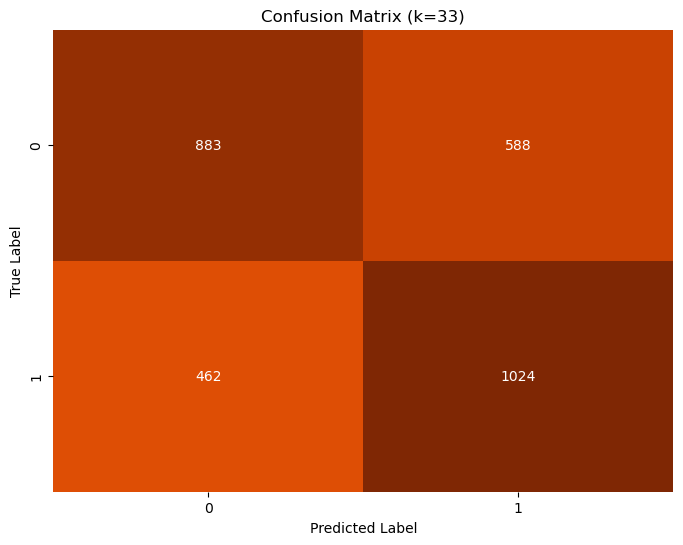

In [66]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False, center=True)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (k={})".format(best_k))
plt.show()

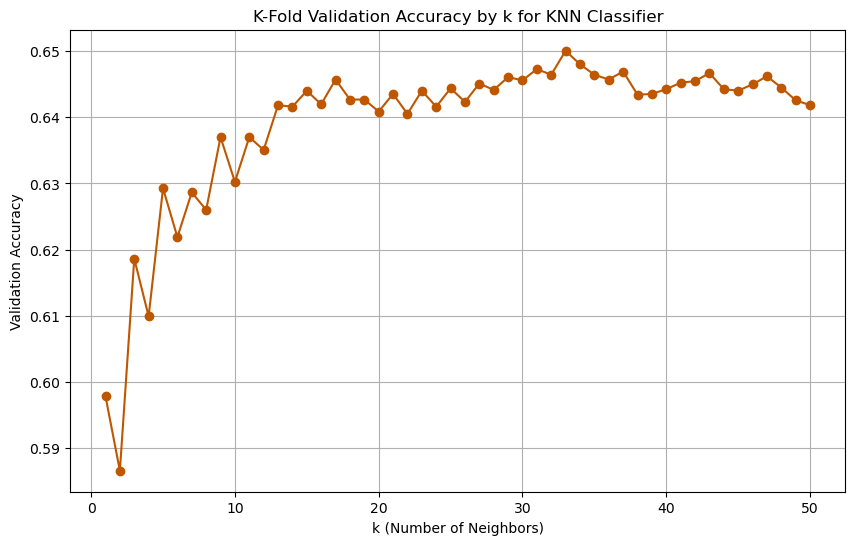

In [67]:
# Generate line graph of all iterations
plt.figure(figsize=(10, 6))
plt.plot(knn_params, accuracies, marker='o', color='#BF5700')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Validation Accuracy')
plt.title('K-Fold Validation Accuracy by k for KNN Classifier')
plt.grid()
plt.show()

## Logistic Regression

In [68]:
# Set the number of folds for cross-validation
k_folds = 5
cv = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store performance metrics for each fold
train_accuracies = []
val_accuracies = []
val_precisions = []
val_recalls = []

for fold_idx, (train_index, val_index) in enumerate(cv.split(X_train, y_train)):
    # Create and train the initial Logistic Regression model on the training data
    initial_logit_model = sm.Logit(
        y_train.iloc[train_index], X_train.iloc[train_index])
    initial_result = initial_logit_model.fit()

    # Print accuracies for the initial model (with all features) on the training and validation sets
    initial_train_prob = initial_result.predict(X_train.iloc[train_index])
    initial_train_pred = (initial_train_prob >= 0.5).astype(int)
    initial_train_accuracy = accuracy_score(
        y_train.iloc[train_index], initial_train_pred)

    initial_val_prob = initial_result.predict(X_train.iloc[val_index])
    initial_val_pred = (initial_val_prob >= 0.5).astype(int)
    initial_val_accuracy = accuracy_score(
        y_train.iloc[val_index], initial_val_pred)
    initial_val_precision = precision_score(
        y_train.iloc[val_index], initial_val_pred)
    initial_val_recall = recall_score(
        y_train.iloc[val_index], initial_val_pred)

    # Store the metrics for each fold
    train_accuracies.append(initial_train_accuracy)
    val_accuracies.append(initial_val_accuracy)
    val_precisions.append(initial_val_precision)
    val_recalls.append(initial_val_recall)

# Print average performance metrics across all folds
print('\n', "Initial Model (With All Features) - Cross-validation Results:")
print("Average Training Accuracy:", np.mean(train_accuracies))
print("Average Validation Accuracy:", np.mean(val_accuracies))
print("Average Precision:", np.mean(val_precisions))
print("Average Recall:", np.mean(val_recalls))

         Current function value: 0.622788
         Iterations: 35
         Current function value: 0.625904
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.622708
         Iterations 30
Optimization terminated successfully.
         Current function value: 0.624986
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.626011
         Iterations 7

 Initial Model (With All Features) - Cross-validation Results:
Average Training Accuracy: 0.6552912744286006
Average Validation Accuracy: 0.6528160164630675
Average Precision: 0.634559296068015
Average Recall: 0.739607303045597


In [69]:
# We want to use a significance level of 0.05
p_values = initial_result.pvalues
significant_features = p_values[p_values < 0.05].index

print('Significant Features:', significant_features, '\n')

# Use only significant features for the final model
X_train_selected = X_train[significant_features]
X_val_selected = X_val[significant_features]

# Train the final logistic regression model using selected features
final_model = sm.Logit(y_train, X_train_selected)
final_result = final_model.fit()

# Make probability predictions on the validation set
y_val_prob = final_result.predict(X_val_selected)

# Find the optimal threshold that maximizes Youden's J statistic
fpr, tpr, thresholds = roc_curve(y_val, y_val_prob)
youden_index = np.argmax(tpr - fpr)
optimal_threshold = thresholds[youden_index]

print('\n', 'Optimal threshold:', optimal_threshold)

# Set the threshold and convert probabilities to binary predictions
y_val_pred = (y_val_prob >= optimal_threshold).astype(int)

# Calculate accuracy, precision, and recall scores on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
roc_auc = roc_auc_score(y_val, y_val_prob)

print("\nModel with Selected Features (Adjusted Threshold):")
print("Validation Accuracy:", accuracy)
print("Validation Precision:", precision)
print("Validation Recall:", recall)
print("ROC AUC Score:", roc_auc)

Significant Features: Index(['sales_channel', 'flight_hour', 'flight_day', 'Continent',
       'flight_time', 'lead_bins'],
      dtype='object') 

Optimization terminated successfully.
         Current function value: 0.637840
         Iterations 5

 Optimal threshold: 0.5061891667659713

Model with Selected Features (Adjusted Threshold):
Validation Accuracy: 0.6376444068751761
Validation Precision: 0.5946771378708552
Validation Recall: 0.7924418604651163
ROC AUC Score: 0.6536187012854908


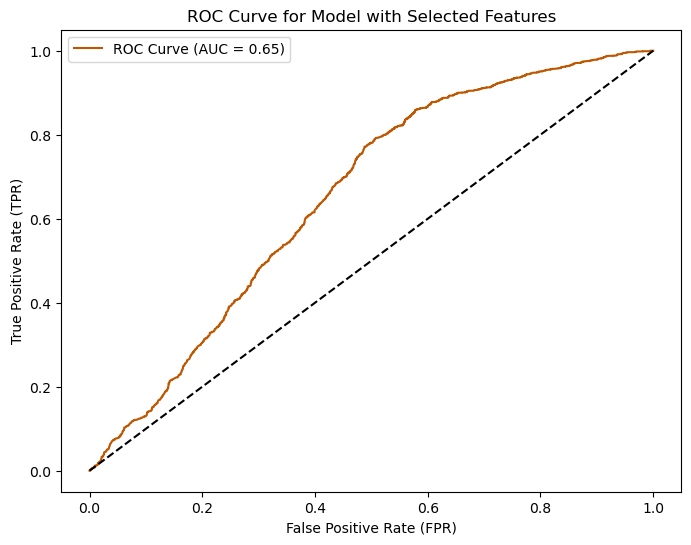

In [70]:
# Plot the ROC curve for the model with selected features
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(
    roc_auc), color='#BF5700')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Model with Selected Features')
plt.legend()
plt.show()

In [71]:
# Train the final model using the best hyperparameters on the training set
final_model = sm.Logit(y_train, X_train_selected)
final_result = final_model.fit()

# Make probability predictions on the testing set
y_test_prob = final_result.predict(X_test[significant_features])

# Set the threshold and convert probabilities to binary predictions
y_test_pred = (y_test_prob >= optimal_threshold).astype(int)

# Calculate accuracy, precision, and recall scores on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("\nTest Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Optimization terminated successfully.
         Current function value: 0.637840
         Iterations 5

Test Accuracy: 0.6526885356780521
Test Precision: 0.6204724409448819
Test Recall: 0.7954239569313594


Confusion Matrix:


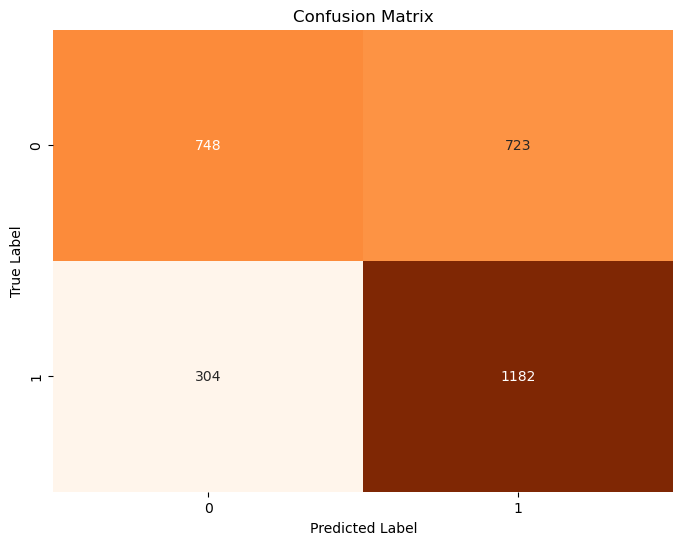

In [72]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

## Decision Tree

In [73]:
# Define parameter combinations for each model
dt_max_depth = [2, 3, 5, 8, 10, 25, 50, 100]
dt_params = dt_max_depth

# Set random seed for reproducibility
np.random.seed(42)

# Initialize a list to store accuracy values
accuracies = []
precisions = []
recalls = []

# Perform k-fold cross-validation for parameter combinations
for max_depth in dt_params:
    print("Testing parameter combination: max_depth={}".format(max_depth))

    # Create the Decision Tree model
    model = DecisionTreeClassifier(max_depth=max_depth, random_state=42)

    # Perform k-fold cross-validation and get accuracy, precision, and recall scores
    cv_scores_accuracy = cross_val_score(
        model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_precision = cross_val_score(
        model, X_train, y_train, cv=5, scoring='precision')
    cv_scores_recall = cross_val_score(
        model, X_train, y_train, cv=5, scoring='recall')

    # Calculate mean scores for accuracy, precision, and recall
    accuracy = np.mean(cv_scores_accuracy)
    precision = np.mean(cv_scores_precision)
    recall = np.mean(cv_scores_recall)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

    print("Cross-Validation Accuracy:", accuracy)
    print("Cross-Validation Precision:", precision)
    print("Cross-Validation Recall:", recall)
    print()

# Find the best hyperparameters based on the validation set performance
best_params_idx = np.argmax(accuracies)
best_max_depth = dt_params[np.argmax(accuracies)]
print("Best max_depth:", best_max_depth)

# Train the final model using the best hyperparameters on the training set
final_model = DecisionTreeClassifier(max_depth=best_max_depth, random_state=42)
final_model.fit(X_train, y_train)

# Make probability predictions on the validation set
y_val_prob = final_model.predict_proba(X_val)

# Set threshold and convert probabilities to binary predictions
y_val_pred = (y_val_prob[:, 1] >= 0.51).astype(int)

# Calculate accuracy, precision, and recall on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)

print("Validation Accuracy:", accuracy)
print("Validation Precision:", precision)
print("Validation Recall:", recall)

Testing parameter combination: max_depth=2
Cross-Validation Accuracy: 0.6548682078900127
Cross-Validation Precision: 0.6512289626731737
Cross-Validation Recall: 0.6839439639809183

Testing parameter combination: max_depth=3
Cross-Validation Accuracy: 0.6720215420990411
Cross-Validation Precision: 0.6465058575340226
Cross-Validation Recall: 0.775679706190138

Testing parameter combination: max_depth=5
Cross-Validation Accuracy: 0.6790286352292132
Cross-Validation Precision: 0.6681212721031191
Cross-Validation Recall: 0.7269461624223346

Testing parameter combination: max_depth=8
Cross-Validation Accuracy: 0.6692463184319221
Cross-Validation Precision: 0.6559727310298845
Cross-Validation Recall: 0.7281397649863275

Testing parameter combination: max_depth=10
Cross-Validation Accuracy: 0.6586153071500503
Cross-Validation Precision: 0.6484222679646117
Cross-Validation Recall: 0.710465265481048

Testing parameter combination: max_depth=25
Cross-Validation Accuracy: 0.5937440343272472
Cross-

In [74]:
# Make probability predictions on the testing set
y_test_prob = final_model.predict_proba(X_test)

# Set threshold and convert probabilities to binary predictions
y_test_pred = (y_test_prob[:, 1] >= 0.51).astype(int)

# Calculate accuracy, precision, and recall on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print('\n', "Final Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)


 Final Test Accuracy: 0.6942847480554616
Test Precision: 0.6841772151898734
Test Recall: 0.7274562584118439


Confusion Matrix:


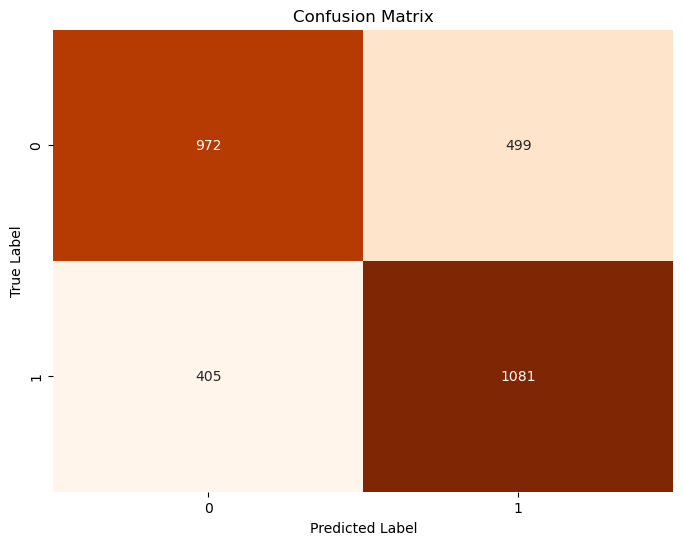

In [75]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

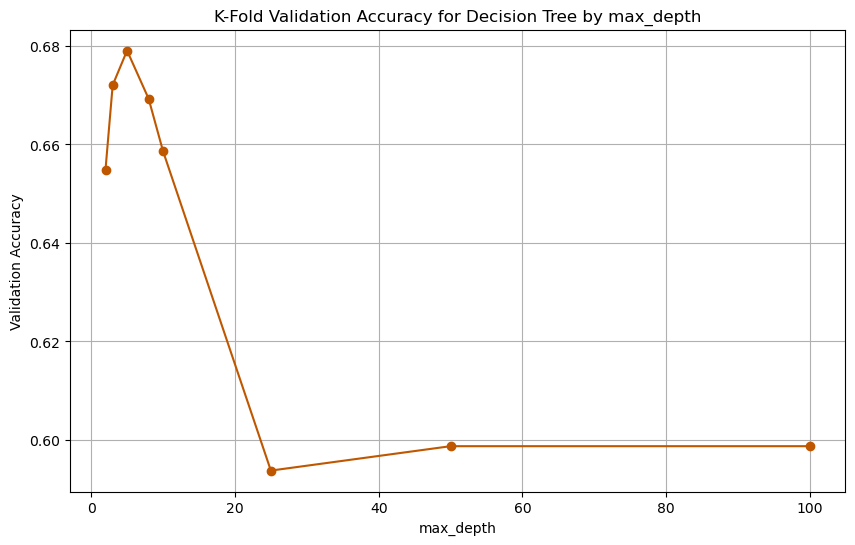

In [76]:
# Generate line graph of all iterations
plt.figure(figsize=(10, 6))
plt.plot(dt_params, accuracies, marker='o', color='#BF5700')
plt.xlabel('max_depth')
plt.ylabel('Validation Accuracy')
plt.title('K-Fold Validation Accuracy for Decision Tree by max_depth')
plt.grid()
plt.show()

## Bagging

In [77]:
# Define parameter combinations for each model
# Number of base estimators (trees)
bagging_n_estimators = [*range(100, 750, 50)]

# Set random seed for reproducibility
np.random.seed(42)

# Initialize lists to store accuracy, precision, and recall values
accuracies = []
precisions = []
recalls = []

# Perform k-fold cross-validation for parameter combinations
for n_estimators in bagging_n_estimators:
    print("Testing parameter combination: n_estimators={}".format(n_estimators))

    # Create the Bagging Classifier with DecisionTree base estimator
    # Base estimator: DecisionTreeClassifier
    base_estimator = DecisionTreeClassifier(max_depth=5, random_state=42)
    model = BaggingClassifier(base_estimator=base_estimator,
                              n_estimators=n_estimators, random_state=42)

    # Perform k-fold cross-validation and get accuracy, precision, and recall scores
    cv_scores_accuracy = cross_val_score(
        model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_precision = cross_val_score(
        model, X_train, y_train, cv=5, scoring='precision')
    cv_scores_recall = cross_val_score(
        model, X_train, y_train, cv=5, scoring='recall')

    # Calculate mean scores for accuracy, precision, and recall
    accuracy = np.mean(cv_scores_accuracy)
    precision = np.mean(cv_scores_precision)
    recall = np.mean(cv_scores_recall)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

    print("Cross-Validation Accuracy:", accuracy)
    print("Cross-Validation Precision:", precision)
    print("Cross-Validation Recall:", recall)
    print()

# Find the best hyperparameter based on the cross-validation performance
best_params_idx = np.argmax(accuracies)
best_n_estimators = bagging_n_estimators[np.argmax(accuracies)]
print("Best n_estimators:", best_n_estimators)

# Train the final model using the best hyperparameter on the full training set
final_model = BaggingClassifier(base_estimator=base_estimator,
                                n_estimators=best_n_estimators, random_state=42)
final_model.fit(X_train, y_train)

# Make probability predictions on the validation set
y_val_prob = final_model.predict_proba(X_val)

# Set threshold and convert probabilities to binary predictions
# raised threshold up to 0.6 since recall was significantly higher than precision
y_val_pred = (y_val_prob[:, 1] > 0.55).astype(int)

# Calculate accuracy, precision, and recall on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)

print("Validation Accuracy:", accuracy)
print("Validation Precision:", precision)
print("Validation Recall:", recall)

Testing parameter combination: n_estimators=100
Cross-Validation Accuracy: 0.6902625625757112
Cross-Validation Precision: 0.6625820728370473
Cross-Validation Recall: 0.789534734518952

Testing parameter combination: n_estimators=150
Cross-Validation Accuracy: 0.690624881416291
Cross-Validation Precision: 0.6616759017183542
Cross-Validation Recall: 0.7943137070398599

Testing parameter combination: n_estimators=200
Cross-Validation Accuracy: 0.6917124947093422
Cross-Validation Precision: 0.6626010395908141
Cross-Validation Recall: 0.7952697866856

Testing parameter combination: n_estimators=250
Cross-Validation Accuracy: 0.6917117649634397
Cross-Validation Precision: 0.6629951011028943
Cross-Validation Recall: 0.7938358097877691

Testing parameter combination: n_estimators=300
Cross-Validation Accuracy: 0.6914697812221784
Cross-Validation Precision: 0.6626118900340107
Cross-Validation Recall: 0.7943131367567429

Testing parameter combination: n_estimators=350
Cross-Validation Accuracy: 

In [78]:
# Make probability predictions on the testing set
y_test_prob = final_model.predict_proba(X_test)

# Set threshold and convert probabilities to binary predictions
y_test_pred = (y_test_prob[:, 1] > 0.55).astype(int)

# Calculate accuracy, precision, and recall on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Test Accuracy: 0.6939465674670274
Test Precision: 0.6917491749174918
Test Recall: 0.7052489905787349


Confusion Matrix:


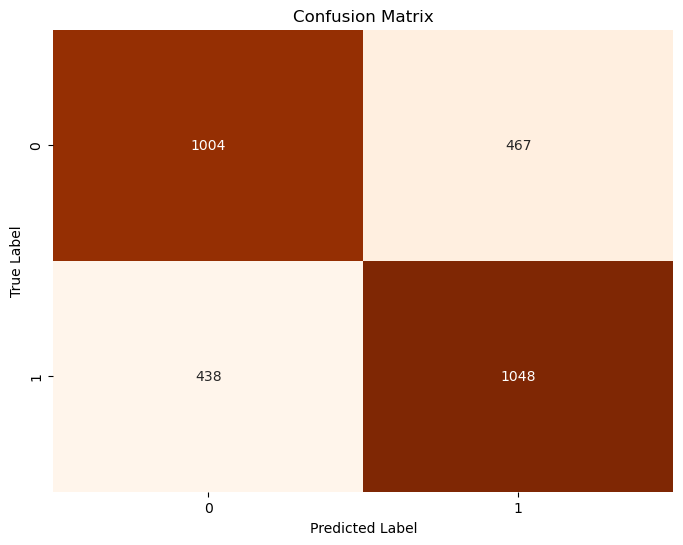

In [79]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

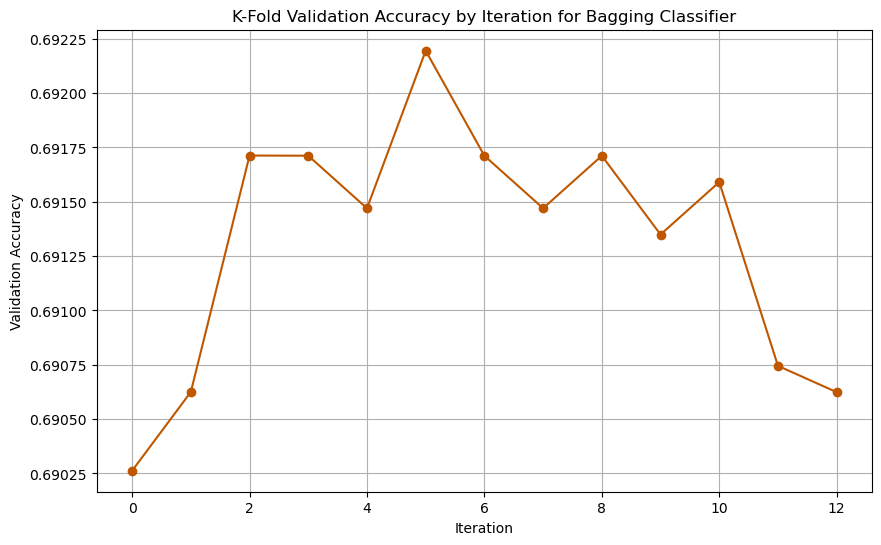

In [80]:
# Generate line graph of all iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracies)), accuracies, marker='o', color='#BF5700')
plt.xlabel('Iteration')
plt.ylabel('Validation Accuracy')
plt.title('K-Fold Validation Accuracy by Iteration for Bagging Classifier')
plt.grid()
plt.show()

## Random Forest

In [81]:
# Define parameter combinations for each model
rf_n_estimators = [50, 100, 500]  # Number of trees in the forest
rf_max_depth = [2, 5, 10]  # Maximum depth of the trees
rf_params = list(product(rf_n_estimators, rf_max_depth))

# Set random seed for reproducibility
np.random.seed(42)

# Initialize a list to store accuracy values
accuracies = []
precisions = []
recalls = []
# Perform k-fold cross-validation for parameter combinations
for params in rf_params:
    n_estimators, max_depth = params
    print("Testing parameter combination: n_estimators={}, max_depth={}".format(
        n_estimators, max_depth))

    # Create the Random Forest model
    model = RandomForestClassifier(
        n_estimators=n_estimators, max_depth=max_depth, random_state=42)

    # Perform k-fold cross-validation and get accuracy, precision, and recall scores
    cv_scores_accuracy = cross_val_score(
        model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_precision = cross_val_score(
        model, X_train, y_train, cv=5, scoring='precision')
    cv_scores_recall = cross_val_score(
        model, X_train, y_train, cv=5, scoring='recall')

    # Calculate mean scores for accuracy, precision, and recall
    accuracy = np.mean(cv_scores_accuracy)
    precision = np.mean(cv_scores_precision)
    recall = np.mean(cv_scores_recall)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

    print("Cross-Validation Accuracy:", accuracy)
    print("Cross-Validation Precision:", precision)
    print("Cross-Validation Recall:", recall)
    print()

# Find the best hyperparameters based on the cross-validation performance
best_params_idx = np.argmax(accuracies)
best_params = rf_params[best_params_idx]
best_n_estimators, best_max_depth = best_params
print("Best hyperparameters: n_estimators={}, max_depth={}".format(
    best_n_estimators, best_max_depth))

# Train the final model using the best hyperparameters on the full training set
final_model = RandomForestClassifier(
    n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=42)
final_model.fit(X_train, y_train)

# Make probability predictions on the validation set using the best model
y_val_prob = final_model.predict_proba(X_val)

# Set threshold at 0.51 and convert probabilities to binary predictions
threshold = 0.51
y_val_pred = (y_val_prob[:, 1] >= threshold).astype(int)

# Calculate accuracy, precision, and recall on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

print("Validation Accuracy:", val_accuracy)
print("Validation Precision:", val_precision)
print("Validation Recall:", val_recall)

Testing parameter combination: n_estimators=50, max_depth=2
Cross-Validation Accuracy: 0.6496740225053637
Cross-Validation Precision: 0.6079740820535187
Cross-Validation Recall: 0.8652657661896248

Testing parameter combination: n_estimators=50, max_depth=5
Cross-Validation Accuracy: 0.6712977801129647
Cross-Validation Precision: 0.6340341544436541
Cross-Validation Recall: 0.8282389942486947

Testing parameter combination: n_estimators=50, max_depth=10
Cross-Validation Accuracy: 0.6866385714494213
Cross-Validation Precision: 0.6646518839388336
Cross-Validation Recall: 0.7677992489371348

Testing parameter combination: n_estimators=100, max_depth=2
Cross-Validation Accuracy: 0.650640279054833
Cross-Validation Precision: 0.608667767158253
Cross-Validation Recall: 0.8659831823508781

Testing parameter combination: n_estimators=100, max_depth=5
Cross-Validation Accuracy: 0.6712973422654231
Cross-Validation Precision: 0.6338782078138009
Cross-Validation Recall: 0.8289552698437139

Testing p

In [82]:
# Make probability predictions on the testing set using the best model
y_test_prob = final_model.predict_proba(X_test)

# Set threshold at 0.51 and convert probabilities to binary predictions
y_test_pred = (y_test_prob[:, 1] >= threshold).astype(int)

# Calculate accuracy, precision, and recall on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("Testing Accuracy:", test_accuracy)
print("Testing Precision:", test_precision)
print("Testing Recall:", test_recall)

Testing Accuracy: 0.6929320257017247
Testing Precision: 0.6696009389671361
Testing Recall: 0.7678331090174967


Confusion Matrix:


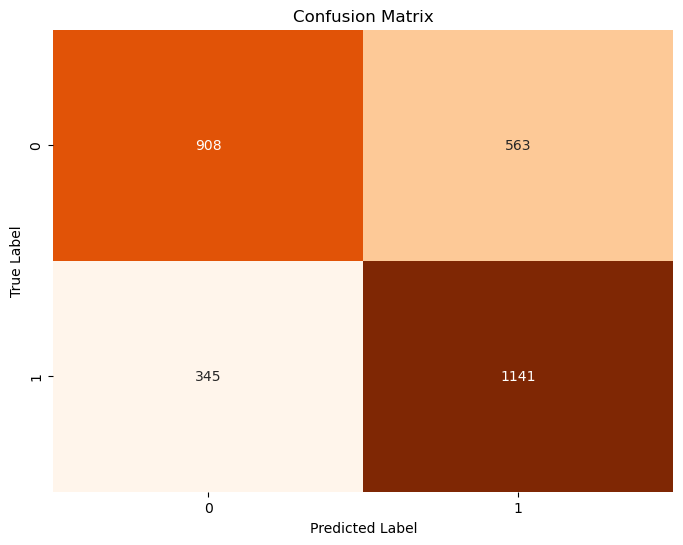

In [83]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

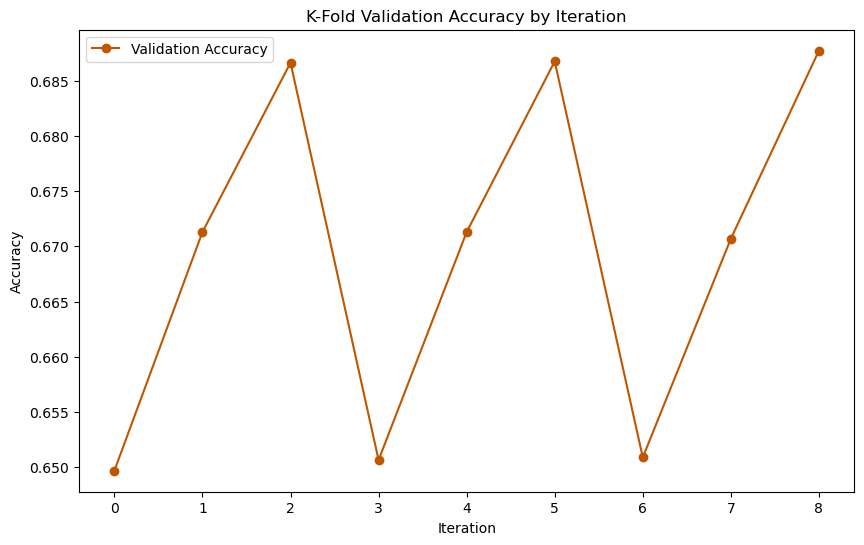

In [84]:
# Generate line graph of all iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracies)), accuracies,
         marker='o', label='Validation Accuracy', color='#BF5700')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('K-Fold Validation Accuracy by Iteration')
plt.legend()
plt.show()

## Gradient Boosting

In [85]:
# Define parameter combinations for each model
gb_n_estimators = [50, 100]
gb_learning_rate = [0.01, 0.1]
dt_max_depth = [2, 5]
gb_params = list(product(gb_n_estimators, gb_learning_rate, dt_max_depth))

# Set random seed for reproducibility
np.random.seed(42)

# Initialize a list to store accuracy values
accuracies = []
precisions = []
recalls = []

# Perform k-fold cross-validation for parameter combinations
for params in gb_params:
    n_estimators, learning_rate, max_depth = params
    print("Testing parameter combination: n_estimators={}, learning_rate={}, max_depth={}".format(
        n_estimators, learning_rate, max_depth))

    # Create the Gradient Boosting classifier
    model = GradientBoostingClassifier(
        n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=42)

    # Perform k-fold cross-validation and get accuracy, precision, and recall scores
    cv_scores_accuracy = cross_val_score(
        model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_precision = cross_val_score(
        model, X_train, y_train, cv=5, scoring='precision')
    cv_scores_recall = cross_val_score(
        model, X_train, y_train, cv=5, scoring='recall')

    # Calculate mean scores for accuracy, precision, and recall
    accuracy = np.mean(cv_scores_accuracy)
    precision = np.mean(cv_scores_precision)
    recall = np.mean(cv_scores_recall)

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

    print("Cross-Validation Accuracy:", accuracy)
    print("Cross-Validation Precision:", precision)
    print("Cross-Validation Recall:", recall)
    print()

# Find the best hyperparameters based on the cross-validation performance
best_params_idx = np.argmax(accuracies)
best_params = gb_params[best_params_idx]
best_n_estimators, best_learning_rate, best_max_depth = best_params
print("Best hyperparameters: n_estimators={}, learning_rate={}, max_depth={}".format(
    best_n_estimators, best_learning_rate, best_max_depth))

# Train the final model using the best hyperparameters on the full training set
final_model = GradientBoostingClassifier(
    n_estimators=best_n_estimators, learning_rate=best_learning_rate, max_depth=best_max_depth, random_state=42)
final_model.fit(X_train, y_train)


# Make probability predictions on the validation set
y_val_prob = final_model.predict_proba(X_val)

# Set threshold and convert probabilities to binary predictions
y_val_pred = (y_val_prob[:, 1] >= 0.51).astype(int)

# Calculate accuracy, precision, and recall on the validation set
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)

print("Validation Accuracy:", accuracy)
print("Validation Precision:", precision)
print("Validation Recall:", recall)

Testing parameter combination: n_estimators=50, learning_rate=0.01, max_depth=2
Cross-Validation Accuracy: 0.6540230161857641
Cross-Validation Precision: 0.6183056570882336
Cross-Validation Recall: 0.8310955423820156

Testing parameter combination: n_estimators=50, learning_rate=0.01, max_depth=5
Cross-Validation Accuracy: 0.6847057664521214
Cross-Validation Precision: 0.6526955980993393
Cross-Validation Recall: 0.8050652546456689

Testing parameter combination: n_estimators=50, learning_rate=0.1, max_depth=2
Cross-Validation Accuracy: 0.6863979012507844
Cross-Validation Precision: 0.6664844412846211
Cross-Validation Recall: 0.760392126671286

Testing parameter combination: n_estimators=50, learning_rate=0.1, max_depth=5
Cross-Validation Accuracy: 0.6912291110235417
Cross-Validation Precision: 0.6771170070549886
Cross-Validation Recall: 0.7443874161327392

Testing parameter combination: n_estimators=100, learning_rate=0.01, max_depth=2
Cross-Validation Accuracy: 0.6490700847964739
Cros

In [86]:
# Make probability predictions on the testing set
y_test_prob = final_model.predict_proba(X_test)

# Set threshold and convert probabilities to binary predictions
y_test_pred = (y_test_prob[:, 1] >= 0.51).astype(int)

# Calculate accuracy, precision, and recall on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Test Accuracy: 0.7017247210010146
Test Precision: 0.6725714285714286
Test Recall: 0.7920592193808883


Confusion Matrix:


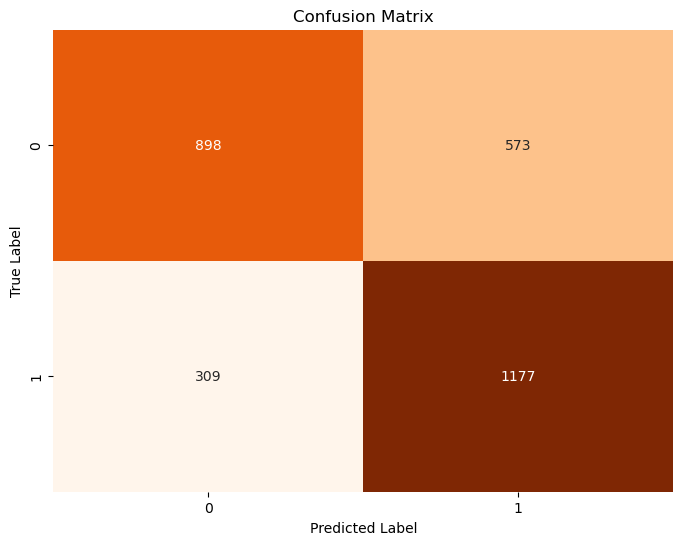

In [87]:
# Calculate Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

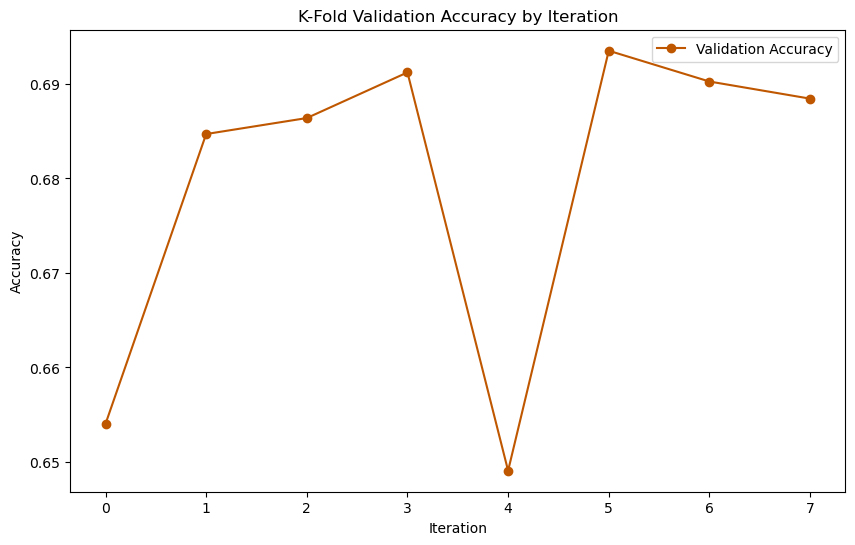

In [88]:
# Generate line graph of all iterations
plt.figure(figsize=(10, 6))
plt.plot(range(len(accuracies)), accuracies,
         marker='o', label='Validation Accuracy', color='#BF5700')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('K-Fold Validation Accuracy by Iteration')
plt.legend()
plt.show()

## Random Search

In [89]:
# Set random seed for reproducibility
np.random.seed(42)

# Define hyperparameter grid for Gradient Boosting Classifier
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['auto', 'sqrt', 'log2'],
}

# Create the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier()

# Perform random search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    gb_classifier, param_distributions=param_dist, n_iter=10, cv=5, n_jobs=-1)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Hyperparameters:", best_params)

# Perform k-fold cross-validation with the best model
cv_scores_accuracy = cross_val_score(
    best_model, X_train, y_train, cv=5, scoring='accuracy')
cv_scores_precision = cross_val_score(
    best_model, X_train, y_train, cv=5, scoring='precision')
cv_scores_recall = cross_val_score(
    best_model, X_train, y_train, cv=5, scoring='recall')

# Calculate mean scores for accuracy, precision, and recall
val_accuracy = np.mean(cv_scores_accuracy)
val_precision = np.mean(cv_scores_precision)
val_recall = np.mean(cv_scores_recall)

print("Cross-Validation Accuracy:", val_accuracy)
print("Cross-Validation Precision:", val_precision)
print("Cross-Validation Recall:", val_recall)

# Make probability predictions on the validation set using the best model
y_val_prob = best_model.predict_proba(X_val)

# Set threshold at 0.5 and convert probabilities to binary predictions
threshold = 0.5
y_val_pred = (y_val_prob[:, 1] >= threshold).astype(int)

# Calculate accuracy score on the validation set
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Make probability predictions on the testing set using the best model
y_test_prob = best_model.predict_proba(X_test)

# Set threshold at 0.5 and convert probabilities to binary predictions
y_test_pred = (y_test_prob[:, 1] >= threshold).astype(int)

# Calculate accuracy, precision, and recall on the testing set
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)

print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

Best Hyperparameters: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 5, 'learning_rate': 0.01}
Cross-Validation Accuracy: 0.6950948669673219
Cross-Validation Precision: 0.6722663105962335
Cross-Validation Recall: 0.7833263473651494
Validation Accuracy: 0.6928712313327698
Test Accuracy: 0.7034156239431857
Test Precision: 0.6715492957746478
Test Recall: 0.8021534320323015


## Variable Importance

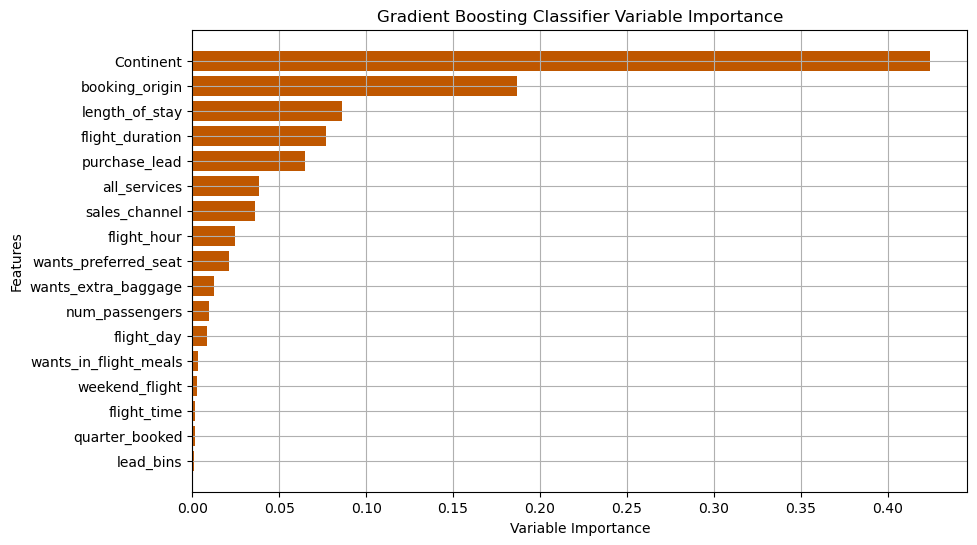

In [90]:
# Get variable importance from the best model
variable_importance = best_model.feature_importances_

# Plot the variable importances as a bar chart
plt.figure(figsize=(10, 6))
sorted_idx = np.argsort(variable_importance)
plt.barh(range(len(variable_importance)),
         variable_importance[sorted_idx], align='center', color='#BF5700')
plt.yticks(range(len(variable_importance)),
           np.array(X_train.columns)[sorted_idx])
plt.xlabel('Variable Importance')
plt.ylabel('Features')
plt.title('Gradient Boosting Classifier Variable Importance')
plt.grid()
plt.show()

## **Findings and Conclusion**
### Process
* Boosting yielded highest accuracy in the Test Dataset.
* Logistic Model, Decision Tree Models are Underfitting as the Test Accuracies are higher than the Validation Accuracies.

### Problem
* Further exploring differences in continent/booking origin (i.e. other factors specific to Asia vs. Oceania) may be key in understanding booking rates.
* Getting more customers to opt into more services may increase booking rates.